In [3]:
from __future__ import print_function, division
import os
import torch
import cv2
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

import pickle as serializer


# this function seperates the different commands in 4 different dictionaries
# DataDict0 is for command0 'continue'
# DataDict1 is for command1 'left' .usw

with open('dataset.txt', 'rb') as f:
    dataset = serializer.load(f)
    
DataDictAll = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}
DataDict0 = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}
DataDict1 = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}
DataDict2 = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}
DataDict3 = {"image":[],"steer":[],"throttle":[],"direction":[],"command":[]}

keys = dataset.keys()
for key in keys:
    for label in dataset[key]:
        #DataDict["image"].append(label[0])
        if label[3] == 'left':
            label[3] = 0
        if label[3] == 'right':
            label[3] = 2
        if label[3] == 'forward':
            label[3] = 1
        if key == 'left':
            key = 1
            '''
            label.append(key)
            DataDict1["image"].append(label[0])
            DataDict1["steer"].append(label[1])
            DataDict1["throttle"].append(label[2])
            DataDict1["direction"].append(label[3])
            DataDict1["command"].append(label[4])
            '''
        if key == 'right':
            key = 3
            '''
            label.append(key)
            DataDict3["image"].append(label[0])
            DataDict3["steer"].append(label[1])
            DataDict3["throttle"].append(label[2])
            DataDict3["direction"].append(label[3])
            DataDict3["command"].append(label[4])
            '''
        if key == 'forward':
            key = 2
            '''
            label.append(key)
            DataDict2["image"].append(label[0])
            DataDict2["steer"].append(label[1])
            DataDict2["throttle"].append(label[2])
            DataDict2["direction"].append(label[3])
            DataDict2["command"].append(label[4])
            '''
        if key == 'continue':
            key = 0
            '''
            label.append(key)
            DataDict0["image"].append(label[0])
            DataDict0["steer"].append(label[1])
            DataDict0["throttle"].append(label[2])
            DataDict0["direction"].append(label[3])
            DataDict0["command"].append(label[4])
            '''
        gut = 'Bilder/'+ label[0]
        if os.path.exists(gut):
            if key == 1:
                label.append(key)
                DataDict1["image"].append(label[0])
                DataDict1["steer"].append(label[1])
                DataDict1["throttle"].append(label[2])
                DataDict1["direction"].append(label[3])
                DataDict1["command"].append(label[4])
            if key == 3:
                label.append(key)
                DataDict3["image"].append(label[0])
                DataDict3["steer"].append(label[1])
                DataDict3["throttle"].append(label[2])
                DataDict3["direction"].append(label[3])
                DataDict3["command"].append(label[4])
            if key == 2:
                label.append(key)
                DataDict2["image"].append(label[0])
                DataDict2["steer"].append(label[1])
                DataDict2["throttle"].append(label[2])
                DataDict2["direction"].append(label[3])
                DataDict2["command"].append(label[4])
            if key == 0:
                label.append(key)
                DataDict0["image"].append(label[0])
                DataDict0["steer"].append(label[1])
                DataDict0["throttle"].append(label[2])
                DataDict0["direction"].append(label[3])
                DataDict0["command"].append(label[4])
            label.append(key)
            DataDictAll["image"].append(label[0])
            DataDictAll["steer"].append(label[1])
            DataDictAll["throttle"].append(label[2])
            DataDictAll["direction"].append(label[3])
            DataDictAll["command"].append(label[4])

print(DataDict0)
with open('DataDictAll.txt', 'wb') as f:
    serializer.dump(DataDictAll, f)

with open('DataDict0.txt', 'wb') as f:
    serializer.dump(DataDict0, f)

with open('DataDict1.txt', 'wb') as f:
    serializer.dump(DataDict1, f)

with open('DataDict2.txt', 'wb') as f:
    serializer.dump(DataDict2, f)

with open('DataDict3.txt', 'wb') as f:
    serializer.dump(DataDict3, f)



In [4]:
# chose the DataSet you want to train the network on
ChosenDataset = 'DataDict1.txt'

with open(ChosenDataset, 'rb') as f:
    dataset = serializer.load(f)

class AISProject(Dataset):
    """ AIS Project dataset."""
    def __init__(self, dictionary, root_dir, transform = None):

        self.dictionary = pd.DataFrame.from_dict(dictionary)
        self.root_dir = root_dir
        self.transform = transform
        print(len(dictionary))
        
    def __len__(self):
        return len(self.dictionary)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.dictionary.iloc[idx,0])
        image = io.imread(img_name)
        #steer = torch.tensor(self.dictionary.iloc[idx,1],dtype=torch.float32, requires_grad=True)
        steer = torch.tensor(self.dictionary.iloc[idx,1],dtype=torch.long)
        speed = torch.tensor(self.dictionary.iloc[idx,2],dtype = torch.float32)
        direction = torch.tensor(self.dictionary.iloc[idx,3],dtype = torch.long)
        command = torch.tensor(self.dictionary.iloc[idx,4],dtype = torch.uint8)
        sample = {'image':image, 'steer': steer, 'speed': speed,'direction':direction, 'command':command }
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [18]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, steer, speed, direction, command = sample['image'], sample['steer'], sample['speed'], sample['direction'], sample['command']
        image = image.transpose((2,0,1))
        return {'image': torch.from_numpy(image), 
                'steer': torch.tensor(steer),
               'speed': torch.tensor(speed),
               'direction':torch.tensor(direction),
               'command':torch.tensor(command)}

In [11]:
class RandomCrop(object):
    """Class to crop our data. (Modified RandomCrop, so that the crop isn't random anymore)"""
    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        #new_h, new_w = output_size
        new_h = 64
        image = image[new_h:h, 0:w]
        #show_image to test whether the pictures are cropped as we wish
        show_image(image)
        sample['image'] = image
        return sample

In [74]:
class RandomHorizontalFlip(object):
    """Class to flip our data horizontally. Only done for left and right turns. (Modified RandomHorizontalFlip,
    so that it isn't random anymore)"""
    def __call__(self, sample):
        """
        Args:
            sample.

        Returns:
            Horizontally flipped sample with adjusted steer and direction. (Must command also be modified?) 
        """
        image, steer, direction, command = sample['image'], sample['steer'], sample['direction'], sample['command']
        if direction == 1:
            image = np.flip(image,axis=1).copy()
            direction = 2
            steer = steer*(-1)
            #command = ....
        elif direction == 2:
            image = np.flip(image,axis=1).copy()
            direction = 1
            steer = steer*(-1)
            #command = ...
        #show_image(image)
        sample['image'] = image
        sample['steer'] = steer
        sample['direction'] = direction
        sample['command'] = command
        return sample



In [78]:
#eventual space for a modified ColorJitter class.

In [79]:
def show_image(image):
    plt.imshow(image)

'''
plt.figure()
show_image(io.imread(os.path.join('Bilder/',img_name)))
plt.show()
'''

"\nplt.figure()\nshow_image(io.imread(os.path.join('Bilder/',img_name)))\nplt.show()\n"

5
5
0 {'image': tensor([[[ 44,  44,  45,  ...,  35,  36,  37],
         [ 42,  41,  42,  ...,  45,  44,  44],
         [ 46,  48,  49,  ..., 164, 164, 163],
         ...,
         [142, 141, 141,  ...,   4,   3,   4],
         [140, 141, 142,  ...,   5,   6,   5],
         [140, 140, 141,  ...,   4,   5,   4]],

        [[ 48,  48,  49,  ...,  39,  41,  41],
         [ 46,  45,  47,  ...,  49,  48,  49],
         [ 50,  52,  53,  ..., 164, 165, 164],
         ...,
         [147, 146, 146,  ...,   6,   5,   5],
         [144, 145, 146,  ...,   7,   7,   7],
         [144, 145, 145,  ...,   6,   7,   6]],

        [[ 32,  33,  33,  ...,  26,  27,  27],
         [ 32,  31,  32,  ...,  36,  35,  35],
         [ 36,  38,  39,  ..., 157, 157, 155],
         ...,
         [143, 142, 143,  ...,   4,   3,   4],
         [141, 142, 143,  ...,   7,   8,   7],
         [142, 142, 143,  ...,   6,   6,   5]]], dtype=torch.uint8), 'steer': tensor(0), 'speed': tensor(0.1000), 'direction': tensor(2), '

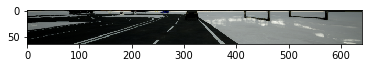

In [80]:
transformed_dataset = AISProject(dictionary = dataset, root_dir='Bilder/', 
                                transform = transforms.Compose([RandomCrop(), RandomHorizontalFlip(), ToTensor(),
                                                               transforms.ColorJitter()]))
transformed_dataset2 = AISProject(dictionary = dataset, root_dir='Bilder/', 
                                transform = transforms.Compose([ToTensor()]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample)
    if i == 1:
        break


In [7]:
TrainData = DataLoader(transformed_dataset, batch_size=32, 
                        shuffle=False, pin_memory=True)
TestData = DataLoader(transformed_dataset2, batch_size=1, 
                        shuffle=False, pin_memory=True)
'''
for batch_idx, dataset in enumerate(TrainData):
    print(batch_idx)
    print(dataset['image'].size())
    print(dataset['command'].size())
    print(dataset['direction'])
    if batch_idx == 3:
        break
'''
'''
def show_labels_batch(sample_batched):
    """Show image with labels for a batch of samples."""
    images_batch, labels_batch = \
        sample_batched['image'], sample_batched['steer']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1,2,0)))



for i_batch, sample_batched in enumerate(TrainData):
    print(i_batch, sample_batched['image'].size(), 
         sample_batched['steer'].size())

    if i_batch == 1:
        plt.figure(figsize=(40,40))
        show_labels_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
'''
        

'\ndef show_labels_batch(sample_batched):\n    """Show image with labels for a batch of samples."""\n    images_batch, labels_batch =         sample_batched[\'image\'], sample_batched[\'steer\']\n    batch_size = len(images_batch)\n    im_size = images_batch.size(2)\n    \n    grid = utils.make_grid(images_batch)\n    plt.imshow(grid.numpy().transpose((1,2,0)))\n\n\n\nfor i_batch, sample_batched in enumerate(TrainData):\n    print(i_batch, sample_batched[\'image\'].size(), \n         sample_batched[\'steer\'].size())\n\n    if i_batch == 1:\n        plt.figure(figsize=(40,40))\n        show_labels_batch(sample_batched)\n        plt.axis(\'off\')\n        plt.ioff()\n        plt.show()\n        break\n'

In [9]:
''' Network with branches '''

device = torch.device("cpu")
# Definition of the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)    # FYI: In the lecture I forgot to add the padding, thats why the feature size calculation was wrong
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(81920, 512)
        self.fc2 = nn.Linear(512, 512)
        #here we start the branching
        # Brach 1
        self.fc1B1 = nn.Linear(512, 256)
        self.fc2B1 = nn.Linear(256, 256)
        self.fc3B1 = nn.Linear(256, 3) # the output is direction
        
        #ToDo: implement other branches
        '''
        # Brach 2
        self.fcB2 = nn.Linear(512, 256)
        self.fcB2 = nn.Linear(256, 256)
        self.fcB2 = nn.Linear(256, 3) # the output is direction
        # Brach 3
        self.fcB3 = nn.Linear(512, 256)
        self.fcB3 = nn.Linear(256, 3) # the output is direction
        # Brach 4
        self.fcB4 = nn.Linear(512, 256)
        self.fcB4 = nn.Linear(256, 3) # the output is direction
        '''

    def forward(self, x, command):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)),2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8_drop(self.conv8(x)))
        x = F.max_pool2d(x,4)
        x = x.view(-1, 81920)   # Flatten data for fully connected layer. Input size is 28*28, we have 2 pooling layers so we pool the spatial size down to 7*7. With 20 feature maps as the output of the previous conv we have in total 7x7x20 = 980 features.
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))
        # choosing the branch
        if command == 0:
            x = F.relu(self.fc1B1(x))
            x = F.relu(self.fc2B1(x))
            x = F.dropout(x, training=self.training)
            x = self.fc3B1(x)
            return F.log_softmax(x, dim=1)

        
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x),2))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(F.max_pool2d(self.conv8_drop(self.conv8(x)), 2))
        x = x.view(-1, 327680)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        '''
# We create the network, shift it on the GPU and define a optimizer on its parameters
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# This function trains the neural network for one epoch
def train(epoch):
    model.train()
    for batch_idx, sample in enumerate(TrainData):
        # Move the input and target data on the GPU
        sample['image'] = sample['image'].type('torch.FloatTensor')
        #sample['direction'] = sample['direction'].type('torch.FloatTensor')
        
        data, target = sample['image'].to(device), sample['direction'].to(device)  # .cuda() works too instead of .to(device)
        command = sample['command']
        if command[0] == 1:
            # Zero out gradients from previous step
            optimizer.zero_grad()
            output = model(data, 0)
            #print("target")
            #print(target.type())
            #output = output.squeeze()
            loss = F.nll_loss(output, target)
            #loss = F.smooth_l1_loss(output, target)
            #loss = loss(output, target)
            loss.backward()
            # Adjusting the parameters according to the loss function
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(TrainData.dataset),
                    100. * batch_idx / len(TrainData), loss.item()))

In [ ]:

def test():
    model.eval()
    test_loss = 0
    correct = 0
    count2 = 0
    with torch.no_grad():
        for sample in TestData:
            datacv = sample['image']
            # Move the input and target data on the GPU
            sample['image'] = sample['image'].type('torch.FloatTensor')
            
            #sample['direction'] = sample['direction'].type('torch.FloatTensor')
            data, target = sample['image'].to(device), sample['direction'].to(device)  # .cuda() works too instead of .to(device)
            command = sample['command']
            if command == 1:
                output = model(data, 0)
                #output = output.squeeze()
                #print(output)
                #if target
                test_loss += F.nll_loss(output, target).item()
                #test_loss += F.smooth_l1_loss(output, target, size_average=False).item() # sum up batch loss
                #test_loss += loss(output, target).item()
                pred = output.max(1, keepdim=True)[1]
                #pred = output # get the index of the max log-probability
                
                if not pred.eq(target.view_as(pred)):   ## If you just want so see the failing examples
                    datacv = datacv.cpu()
                    grid = utils.make_grid(datacv)
                    grid = grid.numpy().transpose((1,2,0))
                    #plt.imshow(grid)
                    #cv_mat = data.cpu().data.squeeze().numpy()
                    #cv_mat = cv2.resize(cv_mat, (128, 640))
                    #plt.figure(figsize=(320,64))
                    cv2.imshow("test image", grid)
                    #plt.axis('off')
                    #plt.ioff()
                    #plt.show()
                    print("Target label is : %d" % target.cpu().item())
                    print("Predicted label is : %d" % (pred.cpu().data.item()))
                    cv2.waitKey()
                 
                correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(TestData.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(TestData.dataset),
        100. * correct / len(TestData.dataset)))
'''
num_train_epochs = 40
for epoch in range(1, num_train_epochs + 1):
    train(epoch)
'''
test()

Target label is : 0
Predicted label is : 1


In [ ]:
loss = nn.L1Loss()
input1 = torch.tensor([-1.88],requires_grad=True,dtype=torch.float32)
input2 = torch.tensor([-1.88],requires_grad=True,dtype=torch.float32)
target = torch.tensor([1],dtype=torch.float64)
b = input2.max(0, keepdim=True)[0]
#output = loss(input1,input2)
print(b)
#output.backward()
#print(output)
print(input1.eq(input2).sum().item())

#x = output.max(0,keepdim=True)[1]
m = input2.view_as(0)
print("m")
print(m)

correct = output.eq(target.view_as(output)).sum().item()
print(correct)
#print(x)

In [ ]:
counter = 0
all = 0
a = torch.tensor([0],dtype=torch.float64)
for batch_idx, sample in enumerate(dataloader2):
    sample = sample.to(device)
    print(sample['steer'])
    break

# This function trains the neural network for one epoch
def train(epoch):
    model.train()
    for batch_idx, sample in enumerate(dataloader):
        # Move the input and target data on the GPU
        sample['image'] = sample['image'].type('torch.FloatTensor')
        sample['steer'] = sample['steer'].type('torch.FloatTensor')
        
        data, target = sample['image'].to(device), sample['steer'].to(device)  # .cuda() works too instead of .to(device)
        #loss = nn.L1Loss()
        # Zero out gradients from previous step
        optimizer.zero_grad()
        output = model(data)
        #print(output.type())
        #print("target")
        #print(target.type())
        #output = output.squeeze()
        #loss = F.nll_loss(output, target)
        loss = F.smooth_l1_loss(output, target)
        #loss = loss(output, target)
        loss.backward()
        # Adjusting the parameters according to the loss function
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))


device = torch.device("cpu")
# Definition of the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)    # FYI: In the lecture I forgot to add the padding, thats why the feature size calculation was wrong
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(327680, 50)
        self.fc2 = nn.Linear(50, 5)
    
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)),2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8_drop(self.conv8(x)))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 327680)   # Flatten data for fully connected layer. Input size is 28*28, we have 2 pooling layers so we pool the spatial size down to 7*7. With 20 feature maps as the output of the previous conv we have in total 7x7x20 = 980 features.
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        
        '''
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x),2))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(F.max_pool2d(self.conv8_drop(self.conv8(x)), 2))
        x = x.view(-1, 327680)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        '''
# We create the network, shift it on the GPU and define a optimizer on its parameters
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
#optimizer = optim.Adam(model.parameters(), lr=0.01)

# This function trains the neural network for one epoch
def train(epoch):
    model.train()
    for batch_idx, sample in enumerate(dataloader):
        # Move the input and target data on the GPU
        sample['image'] = sample['image'].type('torch.FloatTensor')
        sample['steer'] = sample['steer'].type('torch.FloatTensor')
        
        data, target = sample['image'].to(device), sample['steer'].to(device)  # .cuda() works too instead of .to(device)
        #loss = nn.L1Loss()
        # Zero out gradients from previous step
        optimizer.zero_grad()
        output = model(data)
        #print(output.type())
        #print("target")
        #print(target.type())
        #output = output.squeeze()
        #loss = F.nll_loss(output, target)
        loss = F.smooth_l1_loss(output, target)
        #loss = loss(output, target)
        loss.backward()
        # Adjusting the parameters according to the loss function
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample in dataloader2:
            # Move the input and target data on the GPU
            sample['image'] = sample['image'].type('torch.FloatTensor')
            sample['steer'] = sample['steer'].type('torch.FloatTensor')
            #loss = nn.L1Loss()
            data, target = sample['image'].to(device), sample['steer'].to(device)  # .cuda() works too instead of .to(device)
            output = model(data)
            #output = output.squeeze()
            #print(output)
            #test_loss += F.nll_loss(output, target).item()
            test_loss += F.smooth_l1_loss(output, target, size_average=False).item() # sum up batch loss
            #test_loss += loss(output, target).item()
            pred = output.max(1, keepdim=True)[1]
            #print(pred)
            print(target)
            #pred = output # get the index of the max log-probability
            '''
            if not pred.eq(target.view_as(pred)):   ## If you just want so see the failing examples
                cv_mat = data.cuda().data.squeeze().numpy()
                cv_mat = cv2.resize(cv_mat, (400, 400))
                cv2.imshow("test image", cv_mat)
                print("Target label is : %d" % target.cuda().item())
                print("Predicted label is : %d" % (pred.cuda().data.item()))
                cv2.waitKey()
            '''
            correct += pred.eq(target.view_as(pred)).sum().item()


    test_loss /= len(dataloader2.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(dataloader2.dataset),
        100. * correct / len(dataloader2.dataset)))

num_train_epochs = 2
for epoch in range(1, num_train_epochs + 1):
    train(epoch)

test()